# Unsupervised Clustering of motor audio records - 1 sec samples

## import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import json
from sklearn.preprocessing import normalize
from random import randint
from itertools import product
from sklearn.cluster import KMeans
import seaborn as sns

from google.colab import drive
import glob

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


## Reading data

### Mounting google drive and copying data

In [2]:
# Mounting drive
drive.mount('/content/drive')
# Viewing the data in the folder present from the drive
!ls "/content/drive/My Drive/motor_noise_classifier/preprocessed_data"

# copying preprocessed data from Google drive
!cp -r '/content/drive/My Drive/motor_noise_classifier/preprocessed_data' preprocessed_data 

# importing custom functions
!cp -r '/content/drive/My Drive/motor_noise_classifier/my_functions.py' my_functions.py
from my_functions import *

Mounted at /content/drive
melSpec_data_1sec.json		     segments25sec.csv
melSpec_data_2sec.json		     segments2sec.csv
melSpec_data_5sec.json		     segments2sec_overlap.csv
segments1sec.csv		     segments2sec_overlap_newLabels.csv
segments1sec_overlap.csv	     segments5sec.csv
segments1sec_overlap_newLabels.csv   segments5sec_overlap.csv
segments1sec_overlap_newLabels.xlsx  segments5sec_overlap_newLabels.csv


### Reading data

In [9]:
sample_length = 1

# 1 sec samples
# df_src = pd.read_csv("./preprocessed_data/segments1sec.csv", index_col=0)
# mel_spec_metadata_file = 'melSpec_data_1sec.json'

# 1 sec samples overlap
df_src = pd.read_csv("./preprocessed_data/segments1sec_overlap.csv", index_col=0)
mel_spec_metadata_file = 'melSpec_data_1sec.json'


with open(f'./preprocessed_data/{mel_spec_metadata_file}') as json_file:
    melSpec_data = json.load(json_file)

melSpec_data.keys()

dict_keys(['melSpecShape0', 'melSpecShape1', 'n_fft', 'hop_length'])

## Data preparation

### Forming melspectrograms from flat arrays

In [10]:
melSpec_shape = (melSpec_data['melSpecShape0'], melSpec_data['melSpecShape1'])

df = reshapeMelSpecs(df_src, melSpec_shape)
df.sample(5)

(4531, 140, 44)


,motorId,isGood,melSpec
307,2,True,"[[-20.38292501823518, -17.979538419086065, -16..."
4436,23,False,"[[-0.2669890159071926, 0.0, -1.033361706997091..."
141,1,True,"[[-19.645537087879923, -19.94938529775949, -18..."
1057,6,True,"[[-16.3549944350085, -13.378312893666378, -15...."
1260,7,True,"[[-12.581669943062328, -9.310727654725472, -11..."


### Visualising melSpectrogram

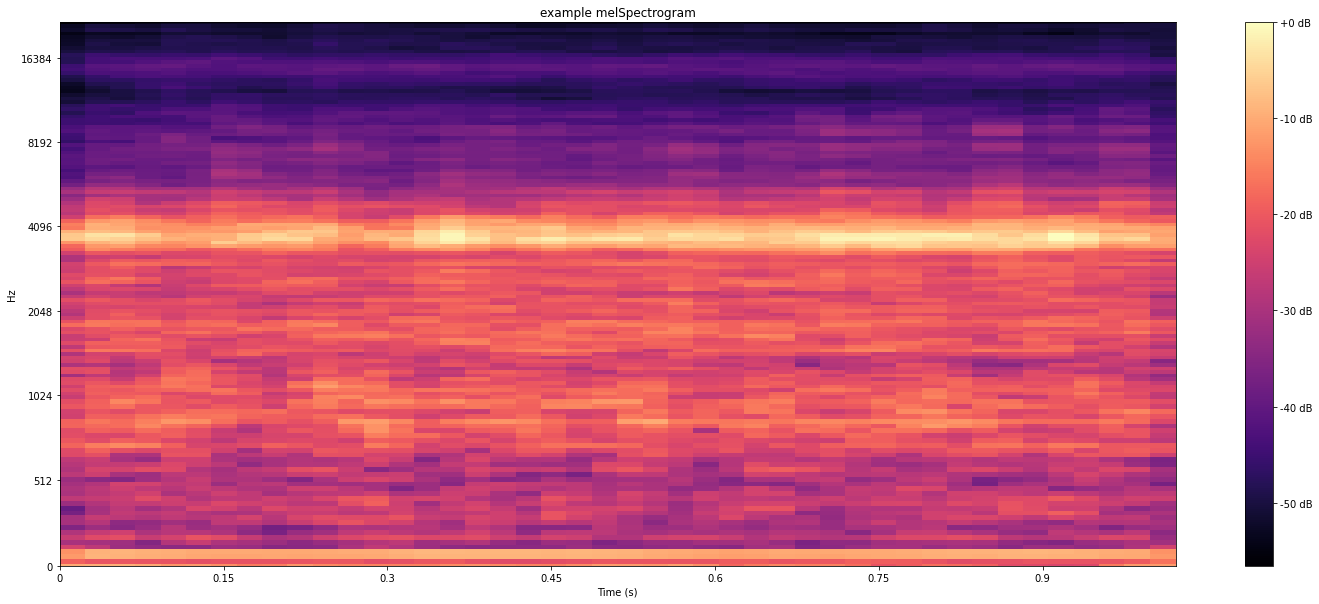

In [11]:
displaySpectrogram(df.melSpec[100], 
                   spec_type='mel',
                   hop_length=melSpec_data['hop_length'],
                   title='example melSpectrogram')

### Train - test sets split

In [12]:
df_shuffled = shuffle(df)

df_train, df_test = train_test_split(df_shuffled, test_size=0.1)

print(f"Shapes:\nTrain/Val: {df_train.shape}\nTest:{df_test.shape}")

# series -> list - > array necessery for proper dimensions
X_train = np.array(list(df_train.melSpec))
y_train = np.array(df_train.isGood)

X_test = np.array(list(df_test.melSpec))
y_test = np.array(df_test.isGood)

motorId_train = np.array(df_train.motorId)
motorId_test = np.array(df_test.motorId)

# total X for clustering
X_total = np.array(list(df_shuffled.melSpec))
y_total = df_shuffled.isGood
motorId_total = df_shuffled.motorId

Shapes:
Train/Val: (4077, 3)
Test:(454, 3)


### Data normalisation with respect to trainset min-max

In [13]:
trainset_minimum = np.min(X_train)
trainset_maximum = np.max(X_train)

X_train = normalise_dataset(X_train, trainset_minimum, trainset_maximum)
X_test = normalise_dataset(X_test, trainset_minimum, trainset_maximum)

X_total = normalise_dataset(X_total, trainset_minimum, trainset_maximum)

# scaler = MinMaxScaler(feature_range=(0, 1))

# scaler.fit_transform(X_train)
# scaler.transform(X_test)
# scaler.transform(X_total)

## Building a stacked AutoEncoder

### Hyperparameters optimization

In [14]:
# Parameters to get checked

AE_architectures = [[250, 100, 30, 100, 250],
                    [500, 250, 50, 250, 500],
                    [250, 100, 30, 15, 30, 100, 250],
                    [1000, 250, 50, 250, 1000]
]

activations = ['relu']#, 'selu']
losses = ['binary_crossentropy', 'mse']
batch_sizes = [16, 32, 128] #, 64, 128]

callbacks = [keras.callbacks.EarlyStopping(
                 monitor="val_loss", 
                 patience=3,
                 verbose=0)
             ]

params = pd.DataFrame(list(product(AE_architectures, activations, losses, batch_sizes)), 
             columns=['AE_architecture', 'activation', 'loss', 'batch_size'])
params

,AE_architecture,activation,loss,batch_size
0,"[250, 100, 30, 100, 250]",relu,binary_crossentropy,16
1,"[250, 100, 30, 100, 250]",relu,binary_crossentropy,32
2,"[250, 100, 30, 100, 250]",relu,binary_crossentropy,128
3,"[250, 100, 30, 100, 250]",relu,mse,16
4,"[250, 100, 30, 100, 250]",relu,mse,32
5,"[250, 100, 30, 100, 250]",relu,mse,128
6,"[500, 250, 50, 250, 500]",relu,binary_crossentropy,16
7,"[500, 250, 50, 250, 500]",relu,binary_crossentropy,32
8,"[500, 250, 50, 250, 500]",relu,binary_crossentropy,128
9,"[500, 250, 50, 250, 500]",relu,mse,16


In [15]:
gridSearchResults = GridSearchAE(params, 
                                 X_train, 
                                 k_folds=4, 
                                 epochs=100, 
                                 callbacks=callbacks, 
                                 melSpec_shape=melSpec_shape)

#1/24
#2/24
#3/24
#4/24
#5/24
#6/24
#7/24
#8/24
#9/24
#10/24
#11/24
#12/24
#13/24
#14/24
#15/24
#16/24
#17/24
#18/24
#19/24
#20/24
#21/24
#22/24
#23/24
#24/24


In [16]:
# sae results of gridSearch to google drive
gridSearchResults.to_json(f'/content/drive/My Drive/motor_noise_classifier/gridSearchResults{sample_length}s.json')
gridSearchResults

,encoder_layers,decoder_layers,loss,activation,MAE,epochs_nb,batch_size
0,"[250, 100, 30]","[100, 250]",binary_crossentropy,relu,0.028486,30.0,16.0
1,"[250, 100, 30]","[100, 250]",binary_crossentropy,relu,0.029216,37.0,32.0
2,"[250, 100, 30]","[100, 250]",binary_crossentropy,relu,0.031791,71.0,128.0
3,"[250, 100, 30]","[100, 250]",mse,relu,0.031244,20.0,16.0
4,"[250, 100, 30]","[100, 250]",mse,relu,0.027493,46.0,32.0
5,"[250, 100, 30]","[100, 250]",mse,relu,0.031001,71.0,128.0
6,"[500, 250, 50]","[250, 500]",binary_crossentropy,relu,0.031476,18.0,16.0
7,"[500, 250, 50]","[250, 500]",binary_crossentropy,relu,0.029222,42.0,32.0
8,"[500, 250, 50]","[250, 500]",binary_crossentropy,relu,0.036901,56.0,128.0
9,"[500, 250, 50]","[250, 500]",mse,relu,0.031612,24.0,16.0


###Building an AutoEncoder with optimal hyperparameters



Reading the optimal hyperparameters

In [ ]:
# download results of GridSearch
!cp -r '/content/drive/My Drive/motor_noise_classifier/gridSearchResults1s.json' gridSearchResults.json


gridSearchResults = pd.read_json('./gridSearchResults.json')#, index_col=False)

In [58]:
best_model = gridSearchResults[gridSearchResults.MAE == gridSearchResults.MAE.min()].iloc[0]
best_model

encoder_layers    [250, 100, 30]
decoder_layers        [100, 250]
loss                         mse
activation                  relu
MAE                     0.027493
epochs_nb                   46.0
batch_size                  32.0
Name: 4, dtype: object

In [59]:
# encoder
hidden_layers_enc = len(best_model.encoder_layers)
encoder = buildAESubmodel(hidden_layers=hidden_layers_enc,
                        neurons_in_layers=best_model.encoder_layers,
                        activations=[best_model.activation for i in range(hidden_layers_enc)],
                        submodel_type='encoder',
                        input_shape=melSpec_shape)

# decoder
hidden_layers_dec = len(best_model.decoder_layers)
decoder = buildAESubmodel(hidden_layers=hidden_layers_dec,
                        neurons_in_layers=best_model.decoder_layers,
                        activations=[best_model.activation for i in range(hidden_layers_dec)],
                        submodel_type='decoder',
                        input_shape=[best_model.encoder_layers[-1]],
                        output_shape=melSpec_shape)

# AutoEncoder
autoencoder = buildModel([encoder, decoder], 
                         loss=best_model.loss, 
                         optimizer='adam')

# train-validation dataset split
partial_X_train, X_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

callbacks = [
             keras.callbacks.EarlyStopping(
                 monitor="val_loss", 
                 patience=3,
                 verbose=0)
             ]

In [60]:
# training 
history = autoencoder.fit(partial_X_train,
                          partial_X_train,
                          epochs=100,
                          validation_data=[X_val, X_val],
                          batch_size=int(best_model.batch_size),
                          callbacks=callbacks
                          )

Epoch 1/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0078 - mae: 0.0649 - val_loss: 0.0062 - val_mae: 0.0621
Epoch 2/100
102/102 [==============================] - 0s 4ms/step - loss: 0.0042 - mae: 0.0498 - val_loss: 0.0038 - val_mae: 0.0466
Epoch 3/100
102/102 [==============================] - 0s 4ms/step - loss: 0.0036 - mae: 0.0461 - val_loss: 0.0036 - val_mae: 0.0454
Epoch 4/100
102/102 [==============================] - 0s 4ms/step - loss: 0.0034 - mae: 0.0439 - val_loss: 0.0033 - val_mae: 0.0431
Epoch 5/100
102/102 [==============================] - 0s 4ms/step - loss: 0.0030 - mae: 0.0416 - val_loss: 0.0029 - val_mae: 0.0408
Epoch 6/100
102/102 [==============================] - 1s 5ms/step - loss: 0.0026 - mae: 0.0392 - val_loss: 0.0026 - val_mae: 0.0392
Epoch 7/100
102/102 [==============================] - 0s 5ms/step - loss: 0.0024 - mae: 0.0377 - val_loss: 0.0023 - val_mae: 0.0370
Epoch 8/100
102/102 [==============================] - 0s 4ms/step - 

In [127]:
# training on all samples
reinitialiseModel(autoencoder)

history_all = autoencoder.fit(X_train,
                              X_train,
                              epochs=int(best_model.epochs_nb) - 2,
                              )

Epoch 1/44
128/128 [==============================] - 0s 4ms/step - loss: 0.0073 - mae: 0.0638
Epoch 2/44
128/128 [==============================] - 0s 3ms/step - loss: 0.0044 - mae: 0.0505
Epoch 3/44
128/128 [==============================] - 0s 4ms/step - loss: 0.0035 - mae: 0.0447
Epoch 4/44
128/128 [==============================] - 0s 3ms/step - loss: 0.0033 - mae: 0.0434
Epoch 5/44
128/128 [==============================] - 0s 4ms/step - loss: 0.0032 - mae: 0.0425
Epoch 6/44
128/128 [==============================] - 0s 3ms/step - loss: 0.0029 - mae: 0.0408
Epoch 7/44
128/128 [==============================] - 0s 3ms/step - loss: 0.0028 - mae: 0.0395
Epoch 8/44
128/128 [==============================] - 0s 3ms/step - loss: 0.0026 - mae: 0.0380
Epoch 9/44
128/128 [==============================] - 0s 3ms/step - loss: 0.0024 - mae: 0.0370
Epoch 10/44
128/128 [==============================] - 0s 4ms/step - loss: 0.0022 - mae: 0.0358
Epoch 11/44
128/128 [============================

### Test set evaluation

In [77]:
test_mse, test_mae = autoencoder.evaluate(X_test, X_test)

15/15 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0287


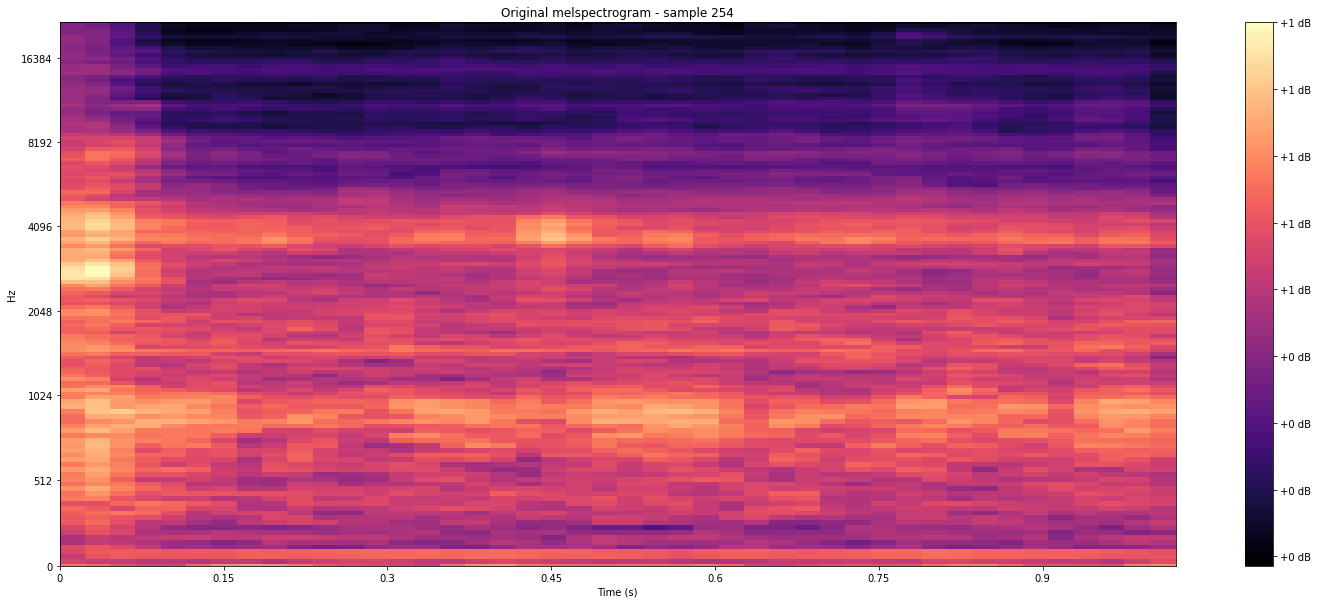

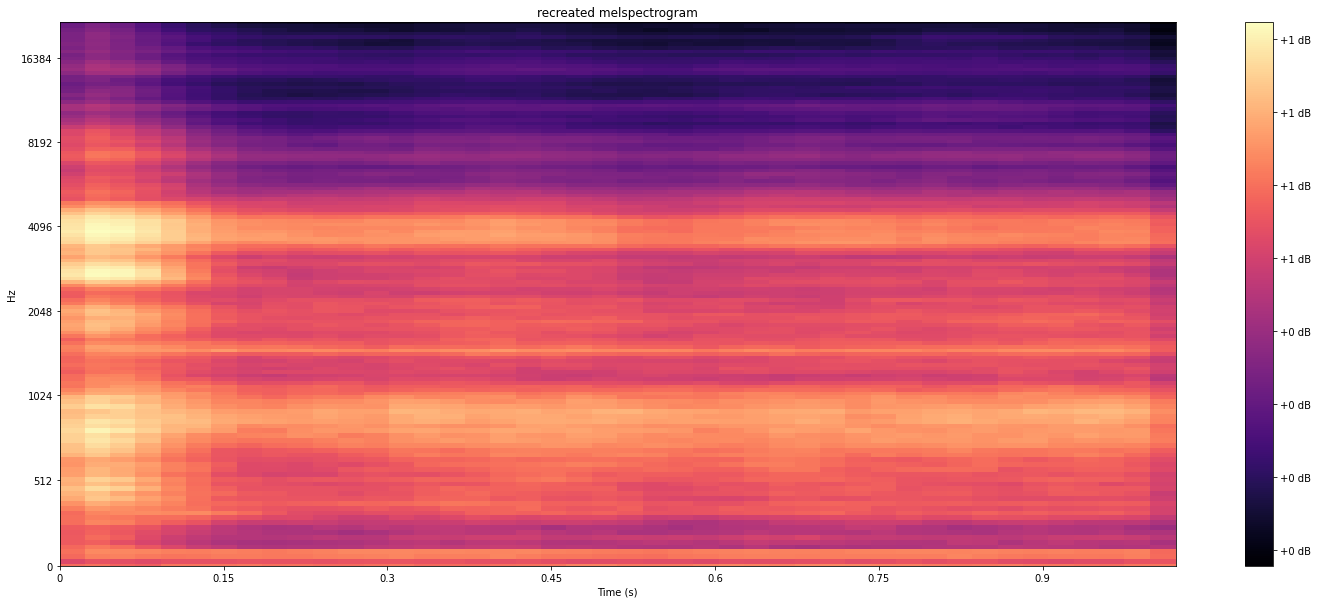

In [63]:
recreated_spectrograms = autoencoder.predict(X_test)

# display a random sample reproduction
random_sample = randint(0, len(X_test))

displaySpectrogram(X_test[random_sample],
                   spec_type="mel", title=f'Original melspectrogram - sample {random_sample}', 
                   hop_length=melSpec_data['hop_length'])

displaySpectrogram(recreated_spectrograms[random_sample],
                   spec_type="mel", title='recreated melspectrogram', 
                   hop_length=melSpec_data['hop_length'])

## Feature Extraction with use of encoder

### Dimensionality reduction with encoder

In [128]:
X_reduced = encoder.predict(X_total)

In [129]:
X_reduced.shape

(4531, 30)

Checking the ranges of the reduced features to recognize features that have no impact on whether the motor is good or bad. Some of the ranges has 0 lengths, that means these features are the same no matter if the label of the motor is good or bad. Therefore we can assume that these features have no impact on the classification of the motor and can be dropped.

The min-max arrays will be also used to make the histograms with the same ranges 

In [130]:
mins_X_reduced = np.min(X_reduced, axis=0)
maxes_X_reduced = np.max(X_reduced, axis=0)
maxes_X_reduced - mins_X_reduced

array([12.765586  ,  0.        ,  0.        , 13.307789  ,  7.608718  ,
        0.        ,  0.        ,  0.        ,  0.        ,  7.8535447 ,
        0.        ,  7.699193  ,  0.        ,  0.        ,  0.        ,
        0.        ,  8.304962  , 11.363406  , 12.052914  ,  9.836485  ,
        0.        ,  0.        ,  0.        ,  8.447256  ,  0.05897462,
        0.        ,  0.        ,  0.        ,  0.        ,  4.3631783 ],
      dtype=float32)

### Histograms of reduced features

In [33]:
X_reduced_good = X_reduced[y_total == 1]
X_reduced_bad = X_reduced[y_total == 0]
print(f"X_reduced_good.shape: {X_reduced_good.shape}\nX_reduced_bad.shape: {X_reduced_bad.shape}")

X_reduced_good.shape: (1970, 30)
X_reduced_bad.shape: (2561, 30)


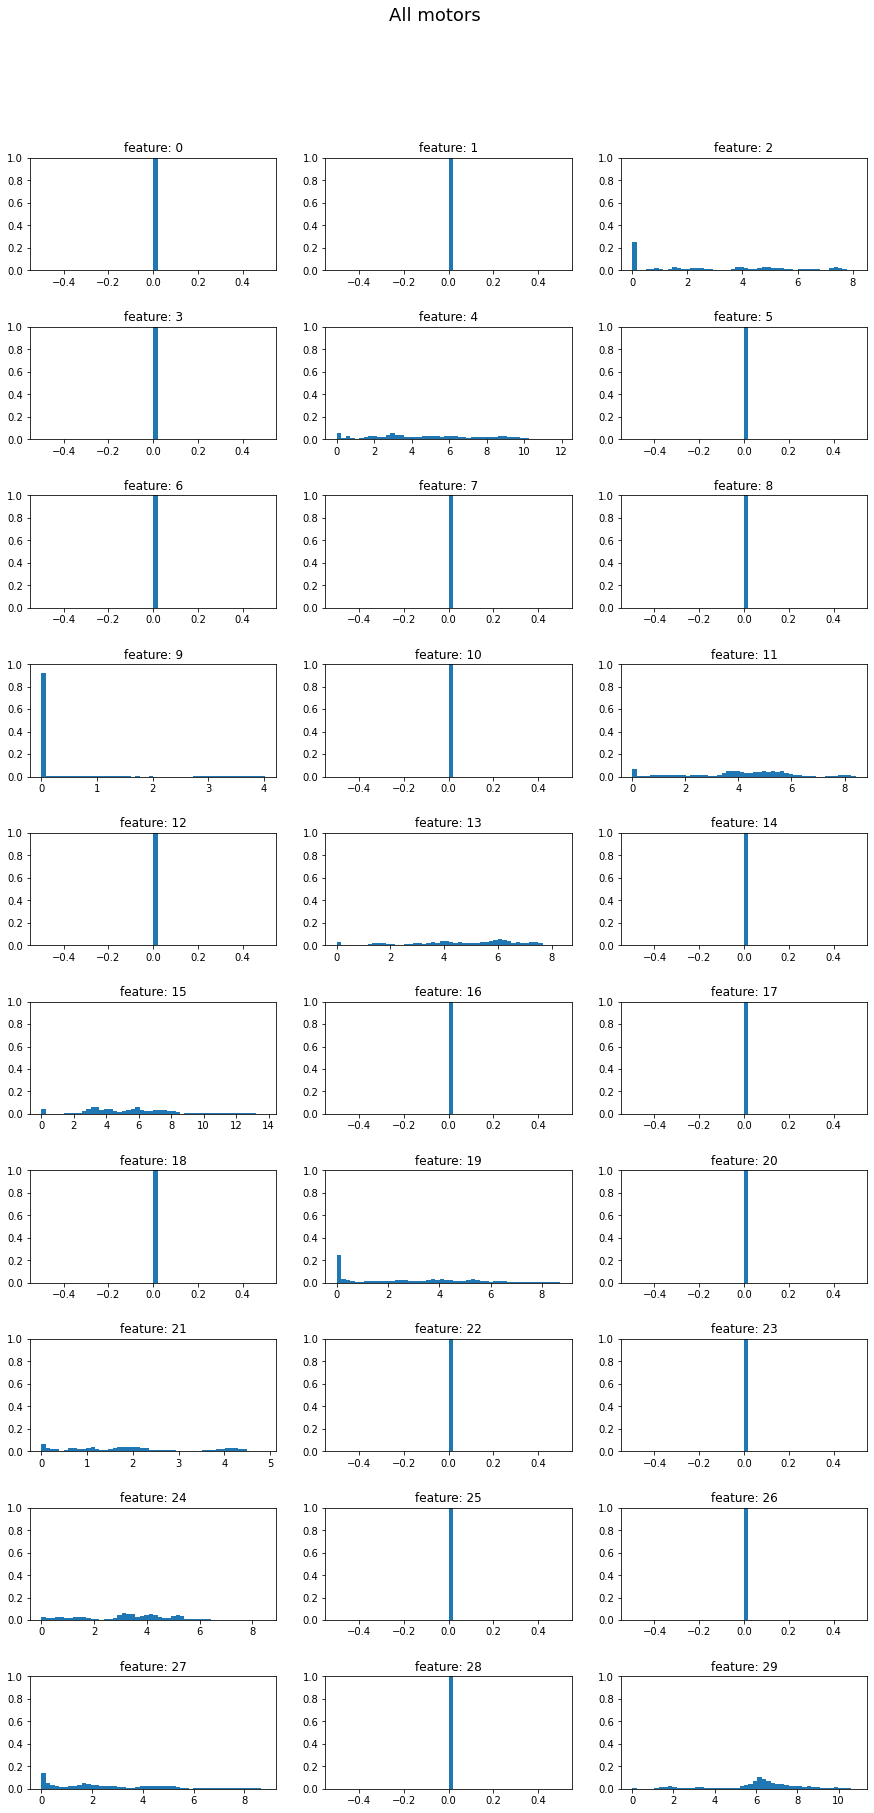

In [34]:
ReducedFeaturesHistograms(X_reduced, mins_X_reduced, maxes_X_reduced, motor_label="All")

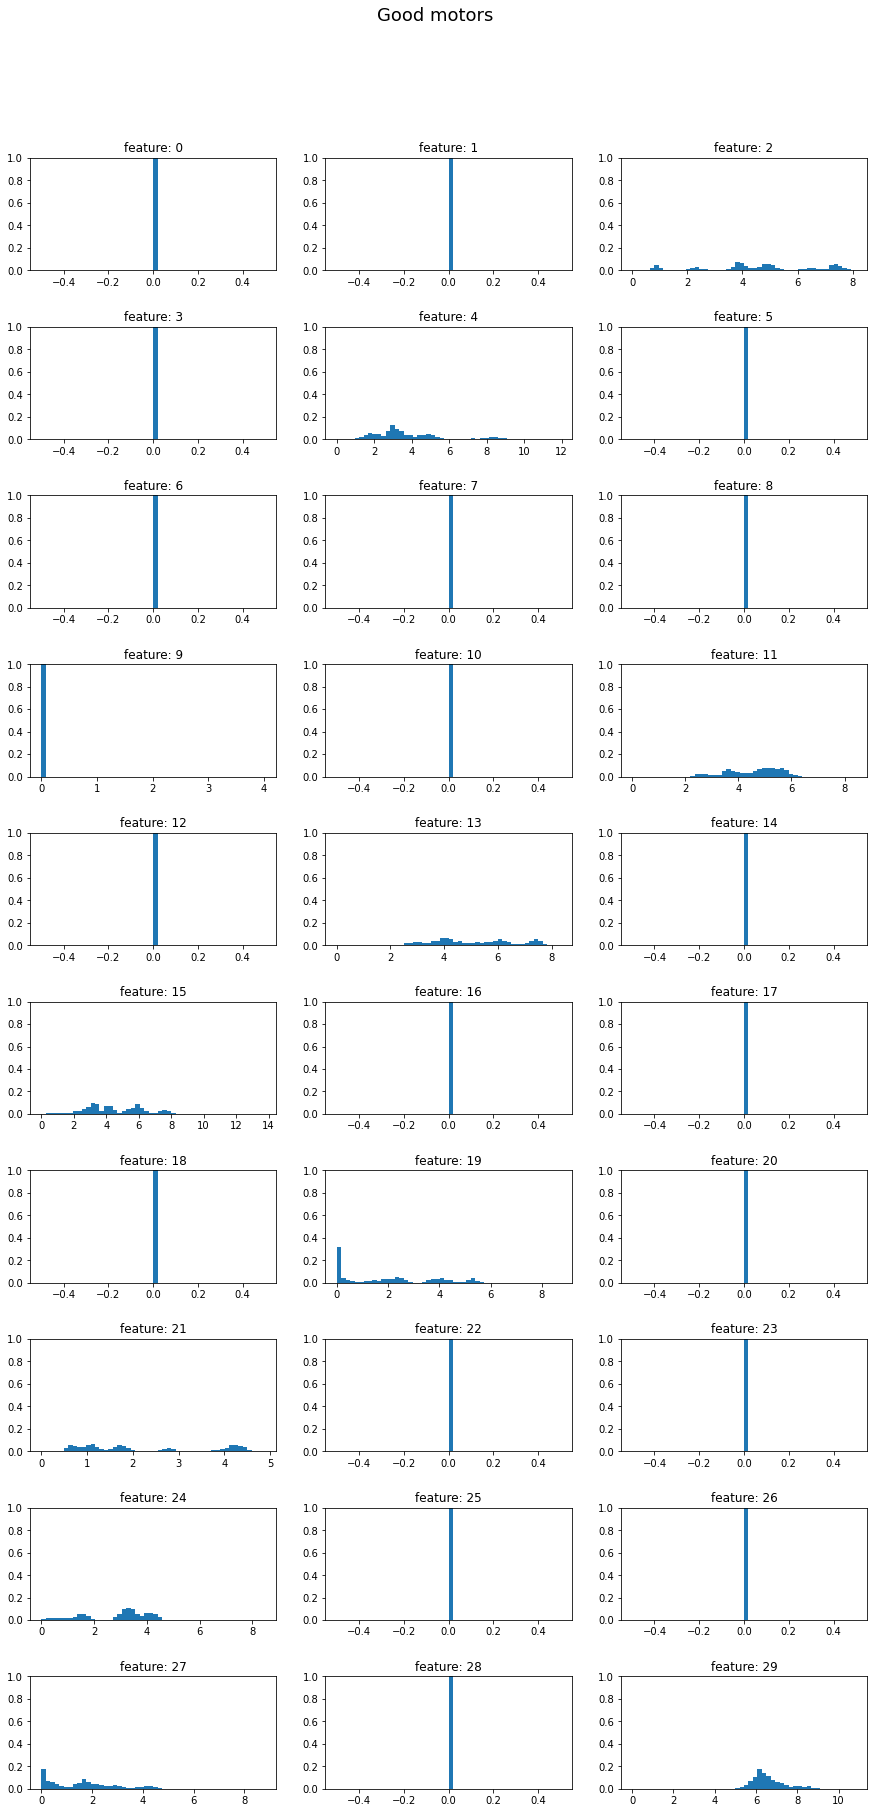

In [35]:
ReducedFeaturesHistograms(X_reduced_good, mins_X_reduced, maxes_X_reduced, motor_label='Good')

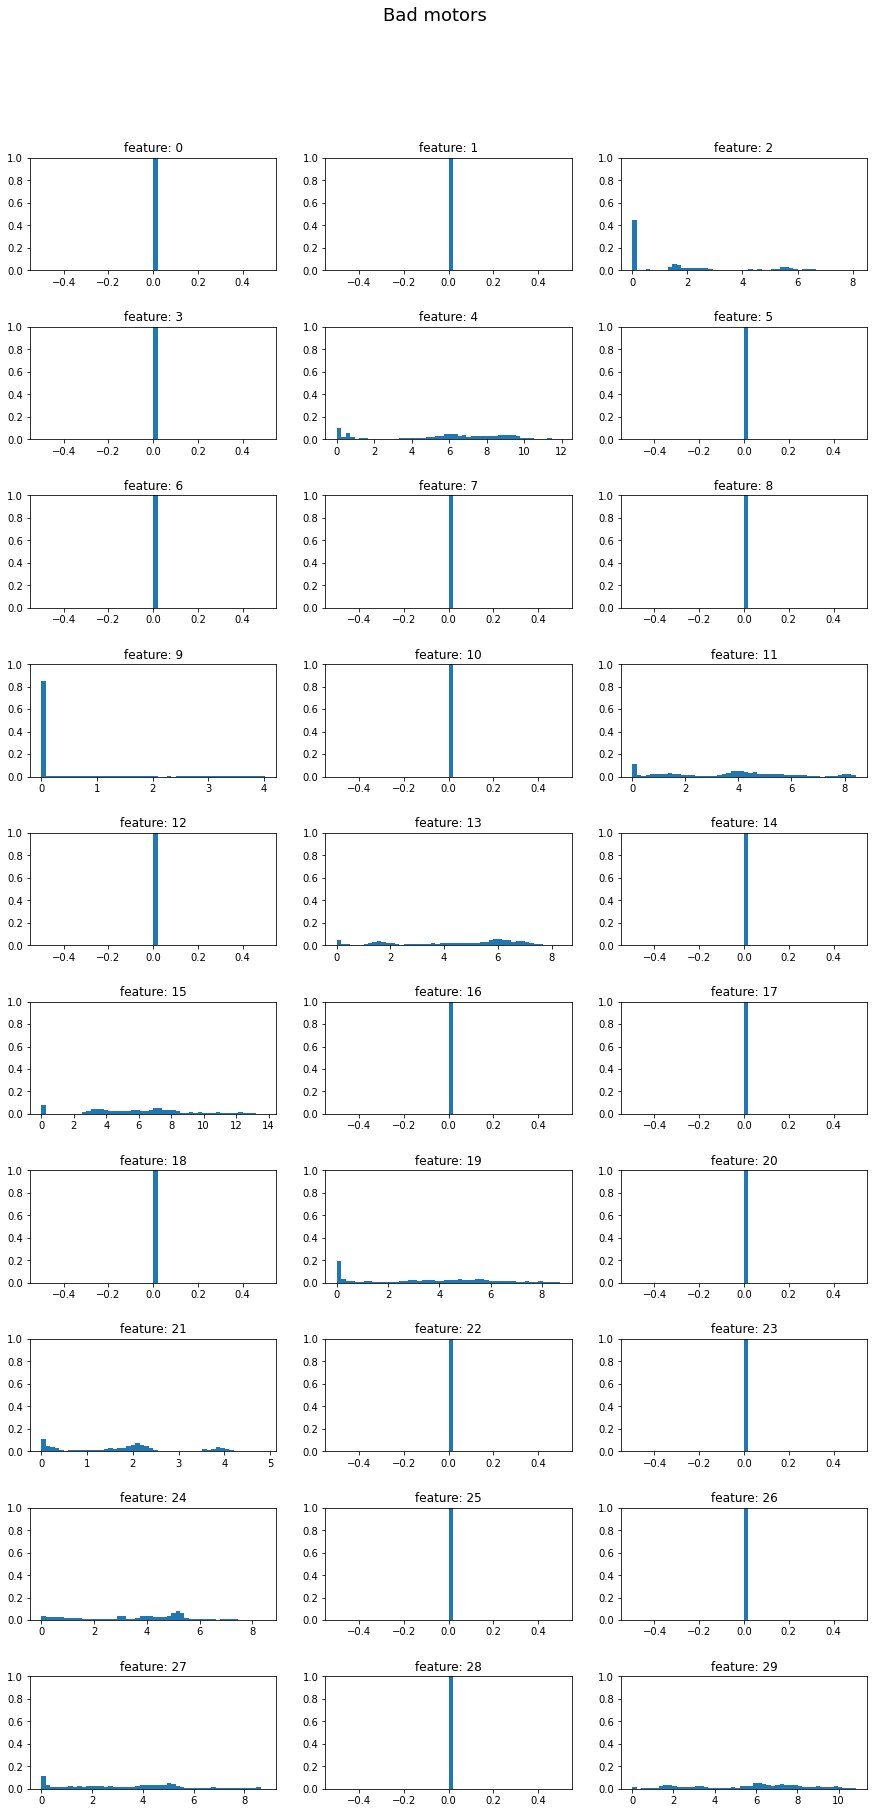

In [36]:
ReducedFeaturesHistograms(X_reduced_bad, mins_X_reduced, maxes_X_reduced, motor_label='Bad')

### Extracting only those features which carry information if the motor is good or bad

In [131]:
notable_features = ExtractNotableFeatures(maxes_X_reduced, mins_X_reduced)
print(f"Notable features: {notable_features}")

Notable features: [0, 3, 4, 9, 11, 16, 17, 18, 19, 23, 24, 29]


In [132]:
X_reduced_notable = np.copy(X_reduced[:, notable_features])
X_reduced_notable.shape

(4531, 12)

#### TSNE

In [133]:
from sklearn.manifold import TSNE

tsne = TSNE()
X_reduced_2D = tsne.fit_transform(X_reduced_notable)
# X_reduced_2D = tsne.fit_transform(X_reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [134]:
data_reduced_2D = pd.DataFrame(np.transpose([X_reduced_2D[:,0], X_reduced_2D[:,1], y_total, motorId_total]),
                               columns=['X_red0', 'X_red1', 'isGood', 'motorId'])
data_reduced_2D

,X_red0,X_red1,isGood,motorId
0,23.673998,-9.750191,1.0,7.0
1,-8.106422,-8.718662,1.0,10.0
2,32.252449,-66.425156,1.0,4.0
3,31.968124,14.848222,0.0,17.0
4,17.286087,-46.518543,1.0,8.0
...,...,...,...,...
4526,68.540916,-3.580758,1.0,5.0
4527,5.113346,63.924248,1.0,6.0
4528,-43.677582,20.640583,0.0,16.0
4529,-46.984928,-15.663864,0.0,23.0


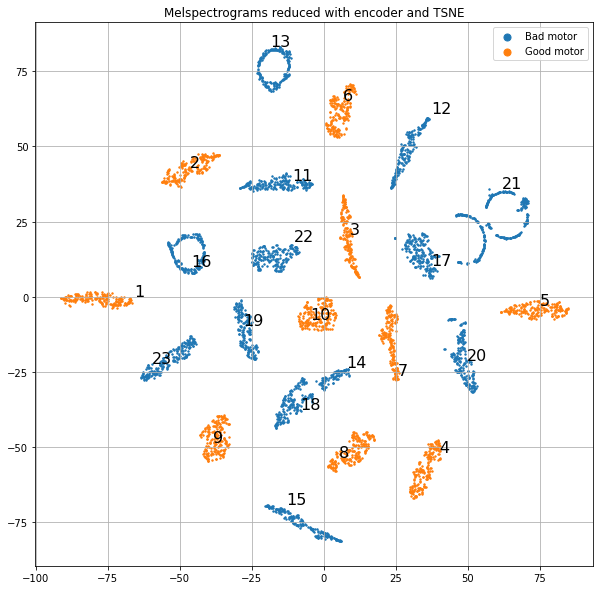

In [135]:
fig, ax = plt.subplots(figsize=(10,10))
nb_of_motors = int(np.max(data_reduced_2D.motorId)) + 1

for label in [0.0, 1.0]:
  X_red = data_reduced_2D[data_reduced_2D.isGood == label]
  legend_label = 'Good motor' if label==1.0 else 'Bad motor'
  ax.scatter(X_red.X_red0, X_red.X_red1, label=legend_label, s=2)

ax.legend(markerscale=5)

printMotorIdAnnotations(nb_of_motors, data_reduced_2D)

ax.set_title('Melspectrograms reduced with encoder and TSNE')
ax.grid(True)
plt.show()

## Clustering

#### K-mean

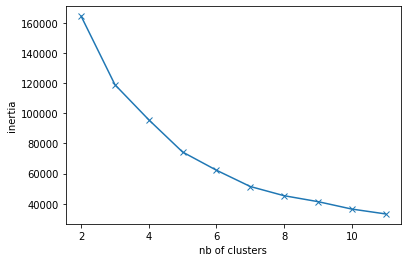

In [136]:
SearchOptimalK(X_reduced)

In [137]:
k = 6
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(X_reduced)

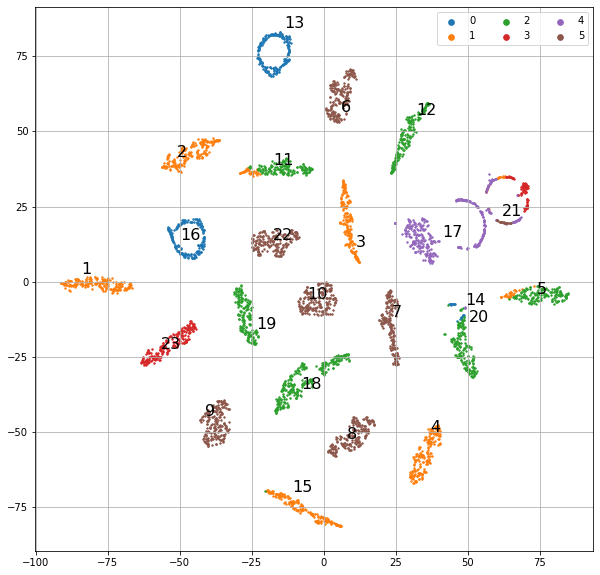

In [138]:
fig, ax = plt.subplots(figsize=(10,10))
nb_of_motors = int(np.max(data_reduced_2D.motorId)) + 1
data_reduced_2D['cluster'] = clusters

for cluster in range(k):
  X_red = data_reduced_2D[data_reduced_2D.cluster == cluster]
  ax.scatter(X_red.X_red0, X_red.X_red1, label=cluster, s=2)

printMotorIdAnnotations(nb_of_motors, data_reduced_2D)

ax.legend(ncol=3, markerscale=4)
ax.grid(True)
plt.show()

#### Heatmap

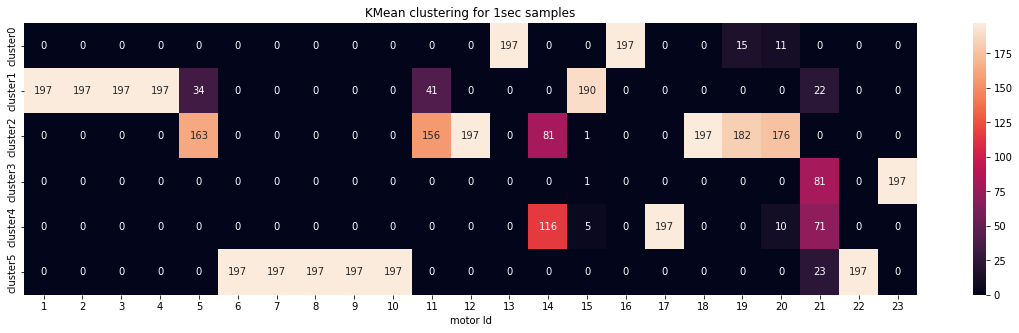

In [139]:
heatmapDF = PrepareClusterHeatmapDF(motorId_total, clusters)

plt.figure(figsize=(20,5))
sns.heatmap(heatmapDF.transpose(), annot=True, fmt='g')
plt.title('KMean clustering for 1sec samples')
plt.xlabel('motor Id')
plt.show()

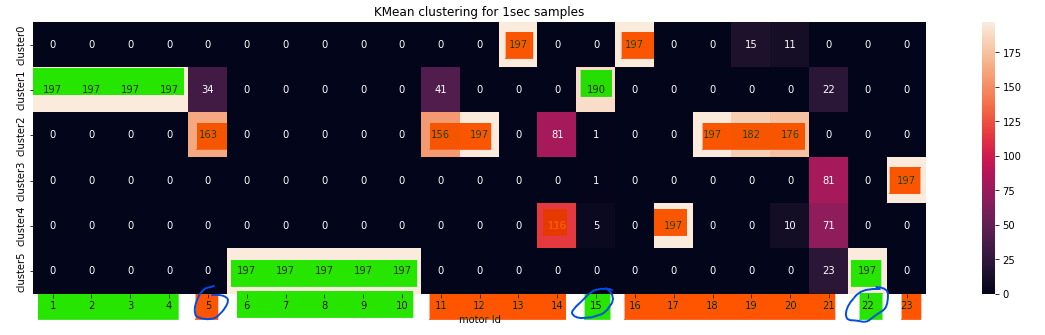

## Changing labels of mislabeled motors

In [141]:
motors_to_change_labels = [5, 15, 22]

df_new_labels = ChangeLabels(df_src, motors_to_change_labels) 
df_new_labels.to_csv(f'/content/drive/My Drive/motor_noise_classifier/preprocessed_data/segments1sec_overlap_newLabels11.csv')